# Section 1 – Chargement et nettoyage des données

Nous chargeons ici **toutes les sources** de données pour un site :  
- NOAA (2 stations)
- Meteostat (2 stations)
- ERA5
- OpenMeteo
- NASA POWER

Toutes les vitesses sont **en m/s**. Aucune valeur aberrante n’est supprimée.


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import weibull_min, genextreme

# 📂 Chemin vers le dossier des données
data_root = "../data"

# 🔍 Lister dynamiquement les dossiers de sites disponibles
site_names = sorted([
    name for name in os.listdir(data_root)
    if os.path.isdir(os.path.join(data_root, name))
])

# 🎛️ Affichage interactif
print("📍 Sites disponibles :")
for i, site in enumerate(site_names):
    print(f"{i+1}. {site}")

# 🧠 Sélection utilisateur
site_index = int(input("\nQuel site veux-tu analyser ? (Numéro) → ")) - 1
site_folder = site_names[site_index]
print(f"✅ Site sélectionné : {site_folder}")

# 🔄 Construction des chemins complets
site_prefix = site_folder.split("_")[-1]
site_path = os.path.join(data_root, site_folder)

sources = {
    "noaa1": f"noaa_station1_{site_prefix}.csv",
    "noaa2": f"noaa_station2_{site_prefix}.csv",
    "meteostat1": f"meteostat1_{site_prefix}.csv",
    "meteostat2": f"meteostat2_{site_prefix}.csv",
    "era5": f"era5_daily_{site_prefix}.csv",
    "nasa": f"nasa_power_{site_prefix}.csv",
    "openmeteo": f"openmeteo_{site_prefix}.csv"
}

# 📚 Chargement des fichiers
dfs = {}
for key, filename in sources.items():
    file_path = os.path.join(site_path, filename)
    try:
        df = pd.read_csv(file_path, parse_dates=["time"])
        dfs[key] = df
        print(f"📁 {key} chargé ({len(df)} lignes)")
    except Exception as e:
        print(f"⚠️ {key} NON chargé : {e}")


📍 Sites disponibles :
1. TEST_PARIS_Montsouris
2. WFR001_PIOLENC
3. WFR006_CARBONNE
4. WFR049_SALLES_SUR_GARONNE
5. WFR066_GROILLONS
6. WFR070_MADONE
7. WFR090_MONPEZAT
8. WIL010_Nofar Pilot
9. WIL017_ASHDOT
10. WIL045_KFAR HAMACCABI (KHM)
11. WIN160_RUMSL
12. WIT001_PONTECORVO
13. WJP104_YAMAKURA
14. WLU001_DIFFERDANGE
15. WNL001_AZALEALAAN
16. WNL005_WATTCO (Pilot)
17. WNL006_ALPEN WATTCO = Maxima Bridge
18. WNL009_ENGIE POND HQ = Engie Zaandam
19. WNL024_BURGUM CENTRAL = Engie Burgum
20. WNL026_OOSTERHOF HOLFMAN
21. WNL031_VELDHUNTEN
22. WNL049_K3
23. WNL059_ZALTBOMMEL
24. WPT008_ALTO_RABAGAO
25. WPT016_SAO LUIS = Cegonha
26. WPT026_CUBA ESTE
27. WSE001_BOR
28. WTW059_CHANGBIN
29. WUK003_QE2
30. WUK013_SHEEPLANDS FARM
31. WUK025_GODLEY RESERVOIR
32. WUK027_KEENS FARM
33. WUK028_WOODLANE
34. WUK029_PARK FARM
35. WUK045_POLYBELL
36. WUK063_REEDERS RESERVOIR
✅ Site sélectionné : WFR001_PIOLENC
⚠️ noaa1 NON chargé : Missing column provided to 'parse_dates': 'time'
⚠️ noaa2 NON chargé : 

# Section 2 – Présentation des données récupérées

Visualisation des **vents moyens** issus de toutes les sources.  
Deux lignes horizontales seront ajoutées plus tard :
- Building Code – vent moyen
- Building Code – vent en rafale


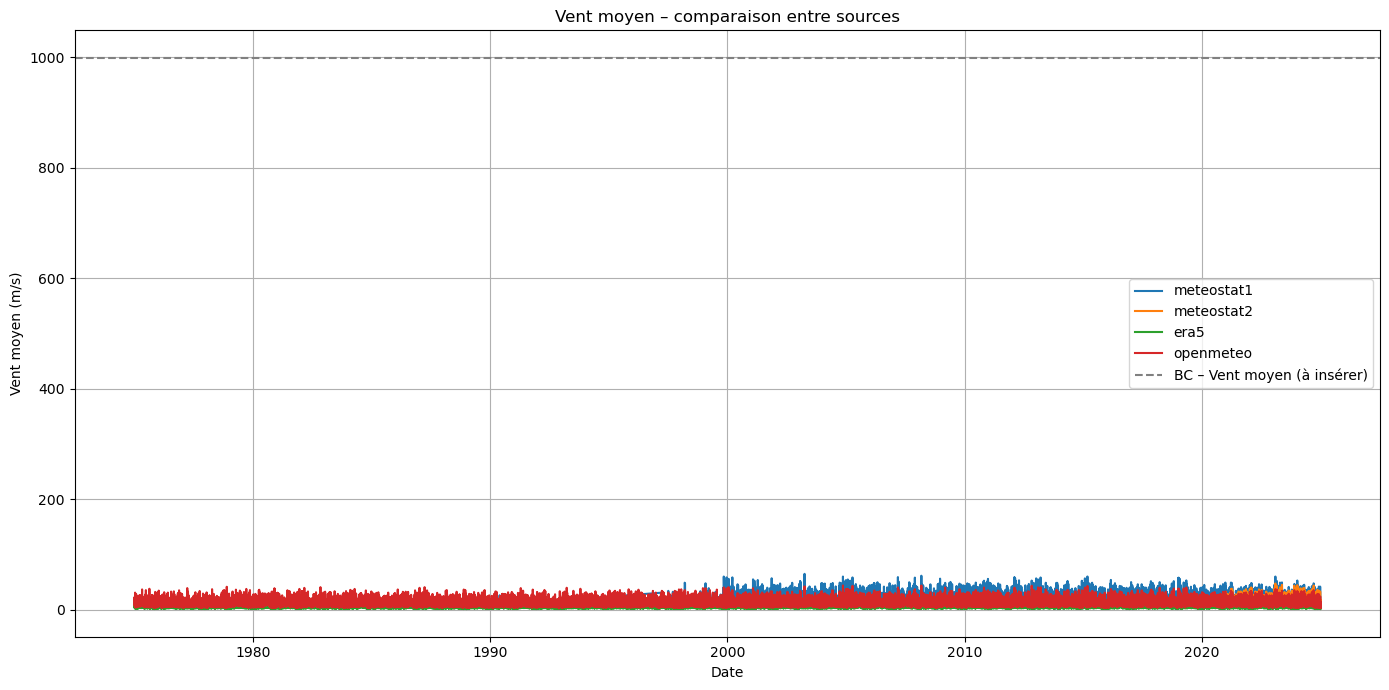

In [7]:
plt.figure(figsize=(14, 7))
for name, df in dfs.items():
    if "windspeed_mean" in df.columns:
        plt.plot(df["time"], df["windspeed_mean"], label=name)

plt.axhline(y=999, color="gray", linestyle="--", label="BC – Vent moyen (à insérer)")
plt.title("Vent moyen – comparaison entre sources")
plt.xlabel("Date")
plt.ylabel("Vent moyen (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Section 3 – Analyse des vents moyens

Nous ajustons ici la **loi de Weibull** sur chaque source de vent moyen.  
Et nous en déduisons la **valeur de retour 50 ans**.


In [8]:
T = 50
for name, df in dfs.items():
    if "windspeed_mean" in df.columns:
        data = df["windspeed_mean"].dropna()
        if len(data) > 0:
            params = weibull_min.fit(data, floc=0)
            v_return = weibull_min.ppf(1 - 1/T, *params)
            print(f"{name} → Vent moyen 50 ans : {v_return:.2f} m/s")


meteostat1 → Vent moyen 50 ans : 46.91 m/s
meteostat2 → Vent moyen 50 ans : 36.30 m/s
era5 → Vent moyen 50 ans : 10.50 m/s
openmeteo → Vent moyen 50 ans : 30.53 m/s


# Section 4 – Analyse des vents rafales

On utilise ici les colonnes `gust` ou `windspeed_gust`.  
On ajuste une **loi GEV complète** sur chaque source, et on extrait :
- Le paramètre \( \xi \)
- Le vent de retour 50 ans


In [9]:
for name, df in dfs.items():
    gust_col = None
    for col in ["gust", "windspeed_gust"]:
        if col in df.columns:
            gust_col = col
            break
    if gust_col:
        data = df[gust_col].dropna()
        if len(data) > 0:
            gev_params = genextreme.fit(data)
            xi = gev_params[0]
            v_return = genextreme.ppf(1 - 1/T, *gev_params)
            print(f"{name} → Rafale 50 ans : {v_return:.2f} m/s (ξ = {xi:.3f})")


meteostat1 → Rafale 50 ans : 95.29 m/s (ξ = -0.036)
openmeteo → Rafale 50 ans : 40.50 m/s (ξ = 0.078)


# Section 5 – Bilan récapitulatif

Nous avons :
- Comparé visuellement toutes les sources
- Ajusté Weibull pour les vents moyens
- Ajusté GEV pour les rafales
- Calculé les valeurs de retour 50 ans

🔜 À venir :
- Ajout des valeurs des Building Codes via Excel
- Extension des rafales estimées via les vents moyens
- Export PDF automatique du notebook complet
